<a href="https://colab.research.google.com/github/beifa/M5_Forecasting/blob/master/nested_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
import pickle
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
%pylab inline

PATH = '/kaggle/input/wmt-inc/'
PATH_PLUS = '/kaggle/input/wmt-plus/'
PATH_WEIGHT = '/kaggle/input/weight-wmt/' #d --> 1158 - 1914
PATH_MODEL = ''

PATH_D1 = ''
PATH_D2 = ''
PATH_D3 = ''

SEED = 13
random.seed(SEED)
np.random.seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


![](https://miro.medium.com/max/1400/1*2-zaRQ-dsv8KWxOlzc8VaA.png)

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

In [ ]:
start = [1633, 1689, 1745, 1801, 1857]

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [ ]:
def read_data(store, end = 0):
    
        
    remove_features = ['id','state_id','store_id', 'd','sales'] 
    
    encode_f = [
        'enc_dept_id_mean',
        'enc_item_id_mean',   
        'enc_item_id_state_id_mean',      
        'enc_item_id_store_id_mean'   
        ]#best var, 0.47034
    
    df = pd.concat([
                pd.read_pickle(PATH_D1),
                pd.read_pickle(PATH_D1),
                pd.read_pickle(PATH_D1)],
                axis =1)
    df= df[df.store_id == store]    
    gc.collect()
    
    
    lags = pd.read_pickle(PATH_D2)
    lags = lags[lags.index.isin(df.index)]
    df = pd.concat([df, lags], axis=1)
    del lags
    gc.collect()
    

    encode = pd.read_pickle(PATH_D3)[encode_f]
    encode = encode[encode.index.isin(df.index)]
    df = pd.concat([df, encode], axis=1)
    del encode
    gc.collect()  
   
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d','sales']+features]
    
    #####folds
    end = end + 56
    print(f'Ends day : {end}')
    df = df[df.d <= end].reset_index(drop=True)
    return df, features

In [ ]:
#from kaggle kernel need tested
#added
from multiprocessing import Pool
import psutil, warnings
warnings.filterwarnings('ignore')
N_CORES = psutil.cpu_count()     # Available CPU cores

# SPLIT = []
# roll = [7, 14, 30, 60]
# for i in roll:
#     for j in roll:
#         SPLIT.append([i, j])

#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
TARGET = 'sales'
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        SPLIT.append([i,j])  
    
        

## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df



def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = df[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [ ]:
def train(df, features,tr_mask, va_mask, lgb_params, seed=False):

    scores = []      
    train_data = lgb.Dataset(df[tr_mask][features], 
                            label=df[tr_mask]['sales'])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    val_data = lgb.Dataset(df[va_mask][features], 
                          label=df[va_mask]['sales'])
    print('Start train lgbm')
    if seed:
        print(f'Seed: {seed}')
        lgb_params.update(
            {'seed': seed} 
            )
    estimator = lgb.train(lgb_params,                          
                          train_data,
                          NUM_ITERATIONS,
                          valid_sets = [val_data],
                          verbose_eval = 100,                        
                          )
    lgb.plot_importance(estimator, figsize=(15,15))
    del train_data, val_data#, estimator
    gc.collect()
    print('Ends')
    return estimator

In [ ]:
def make_relo(df, st, interval=100, reroll = True):
    pred_mask = df.d > (st - interval)    
    temp_df = df[pred_mask].reset_index(drop=True) #1913-100
    if reroll:       
        keep_cols = [col for col in list(temp_df) if '_tmp_' not in col]         
        temp_df = temp_df[keep_cols]
    #display(temp_df)
    return temp_df
    
def predic(model, st, temp_df, features, reroll = True):
    """
    model- lgbm
    st - fold
    temp_df -  interval    
    reroll - roling with window slice
    """
    display(temp_df)
    #3 month interval, need test
    print('predict starts')
    last_idx = temp_df.shape[0]  
    if reroll:        
        #add for rolling fo 3 month 
        temp_df = pd.concat([temp_df, df_parallelize_run(make_lag_roll, SPLIT)], axis=1)
    #only test    
    temp_df = temp_df.iloc[:last_idx]
    temp_df = temp_df[temp_df.d > st + 28]    
    temp_df['pred'] = np.nan   
    print('------------')
    #display(temp_df)
    for d in range(1, 29):
        #print(f'Predict: {st+28+ d}')         
        day_mask = temp_df['d'] == ((st+28)  + d) #1 day         
        temp_df.loc[day_mask, 'pred'] = model.predict(temp_df[day_mask][features])    
    error = rmse(temp_df['sales'], temp_df.pred)
    return error

In [ ]:
# lgb_params = {
#     'boosting_type': 'gbdt', 
#     'objective': 'regression',
#     'objective': 'tweedie',
#     'tweedie_variance_power': 1.1,
#     'metric': 'rmse',        
#     'subsample': 0.8,        
#     'subsample_freq': 1,
#     'learning_rate': 0.05,     
#     'num_leaves': 128,      
#     'min_data_in_leaf': 256,
#     'feature_fraction': 0.8,    
#     'seed':13,
#     'verbose': -1
#     } 

CA_1
Fold 1
Ends day : 1689
Start train lgbm
[100]	valid_0's rmse: 2.19415
[200]	valid_0's rmse: 2.16833
[300]	valid_0's rmse: 2.15827
[400]	valid_0's rmse: 2.15295
[500]	valid_0's rmse: 2.14958
Ends


,id,d,sales,item_id,dept_id,cat_id,release,sell_price,price_max,price_min,...,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,enc_dept_id_mean,enc_item_id_mean,enc_item_id_state_id_mean,enc_item_id_store_id_mean
0,HOBBIES_1_001_CA_1_validation,1534,1.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,224,8.257812,9.578125,8.257812,...,0.766602,1.005859e+00,0.700195,0.907715,0.649902,0.930176,0.865234,0.405762,0.626465,0.589844
1,HOBBIES_1_002_CA_1_validation,1534,0.0,HOBBIES_1_002,HOBBIES_1,HOBBIES,20,3.970703,3.970703,3.970703,...,0.133301,3.457031e-01,0.099976,0.302490,0.316650,0.646973,0.865234,0.274658,0.219360,0.278076
2,HOBBIES_1_003_CA_1_validation,1534,1.0,HOBBIES_1_003,HOBBIES_1,HOBBIES,300,2.970703,2.970703,2.970703,...,0.399902,6.748047e-01,0.383301,0.584961,0.172241,0.433594,0.865234,0.185425,0.250244,0.353760
3,HOBBIES_1_004_CA_1_validation,1534,0.0,HOBBIES_1_004,HOBBIES_1,HOBBIES,5,4.640625,4.640625,4.339844,...,2.300781,2.878906e+00,2.367188,2.851562,2.339844,2.695312,0.865234,2.064453,2.998047,1.750977
4,HOBBIES_1_005_CA_1_validation,1534,1.0,HOBBIES_1_005,HOBBIES_1,HOBBIES,16,2.880859,3.080078,2.480469,...,1.200195,9.965820e-01,1.166992,1.060547,1.200195,1.427734,0.865234,0.812012,1.032227,1.026367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474150,FOODS_3_823_CA_1_validation,1689,1.0,FOODS_3_823,FOODS_3,FOODS,127,2.880859,2.980469,2.480469,...,1.433594,1.250977e+00,1.500000,1.228516,1.161133,1.134766,2.623047,0.841797,1.460938,0.807129
474151,FOODS_3_824_CA_1_validation,1689,0.0,FOODS_3_824,FOODS_3,FOODS,0,2.679688,2.679688,2.470703,...,0.000000,5.960464e-08,0.000000,0.000000,0.172241,0.851074,2.623047,0.435059,0.582520,0.712891
474152,FOODS_3_825_CA_1_validation,1689,0.0,FOODS_3_825,FOODS_3,FOODS,1,3.980469,4.378906,3.980469,...,0.833496,8.745117e-01,0.899902,0.986328,1.105469,1.095703,2.623047,0.708008,0.812012,0.962402
474153,FOODS_3_826_CA_1_validation,1689,0.0,FOODS_3_826,FOODS_3,FOODS,211,1.280273,1.280273,1.280273,...,0.199951,7.612305e-01,0.950195,1.477539,1.272461,1.535156,2.623047,1.113281,1.322266,1.590820


predict starts
------------
Store CA_1 Fold 1, interval train < 1633 valid 1633-1661, test > 1661: Valid--> 2.149576417891307, Predict--> 4.299608730017844
Ends
Fold 2
Ends day : 1745
Start train lgbm
[100]	valid_0's rmse: 2.13967
[200]	valid_0's rmse: 2.10257
[300]	valid_0's rmse: 2.09159
[400]	valid_0's rmse: 2.08923
[500]	valid_0's rmse: 2.08601
Ends


,id,d,sales,item_id,dept_id,cat_id,release,sell_price,price_max,price_min,...,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,enc_dept_id_mean,enc_item_id_mean,enc_item_id_state_id_mean,enc_item_id_store_id_mean
0,HOBBIES_1_001_CA_1_validation,1590,0.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,224,8.257812,9.578125,8.257812,...,0.533203,6.816406e-01,0.700195,0.720215,0.705566,9.375000e-01,0.865234,0.405762,0.626465,0.589844
1,HOBBIES_1_002_CA_1_validation,1590,0.0,HOBBIES_1_002,HOBBIES_1,HOBBIES,20,3.970703,3.970703,3.970703,...,0.166626,3.791504e-01,0.133301,0.342773,0.250000,5.966797e-01,0.865234,0.274658,0.219360,0.278076
2,HOBBIES_1_003_CA_1_validation,1590,1.0,HOBBIES_1_003,HOBBIES_1,HOBBIES,300,2.970703,2.970703,2.970703,...,0.199951,4.067383e-01,0.233276,0.426514,0.216675,4.519043e-01,0.865234,0.185425,0.250244,0.353760
3,HOBBIES_1_004_CA_1_validation,1590,2.0,HOBBIES_1_004,HOBBIES_1,HOBBIES,5,4.640625,4.640625,4.339844,...,2.666016,2.496094e+00,2.433594,2.625000,2.539062,2.800781e+00,0.865234,2.064453,2.998047,1.750977
4,HOBBIES_1_005_CA_1_validation,1590,0.0,HOBBIES_1_005,HOBBIES_1,HOBBIES,16,2.880859,3.080078,2.480469,...,1.266602,1.201172e+00,1.216797,1.166016,1.216797,1.247070e+00,0.865234,0.812012,1.032227,1.026367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474497,FOODS_3_823_CA_1_validation,1745,1.0,FOODS_3_823,FOODS_3,FOODS,127,2.500000,2.980469,2.480469,...,1.133789,1.224609e+00,1.116211,1.106445,1.200195,1.165039e+00,2.623047,0.841797,1.460938,0.807129
474498,FOODS_3_824_CA_1_validation,1745,0.0,FOODS_3_824,FOODS_3,FOODS,0,2.679688,2.679688,2.470703,...,0.000000,5.960464e-08,0.000000,0.000000,0.000000,5.960464e-08,2.623047,0.435059,0.582520,0.712891
474499,FOODS_3_825_CA_1_validation,1745,0.0,FOODS_3_825,FOODS_3,FOODS,1,3.980469,4.378906,3.980469,...,0.933105,1.229492e+00,1.116211,1.194336,1.044922,1.082031e+00,2.623047,0.708008,0.812012,0.962402
474500,FOODS_3_826_CA_1_validation,1745,0.0,FOODS_3_826,FOODS_3,FOODS,211,1.280273,1.280273,1.280273,...,0.000000,1.788139e-07,0.183350,0.747559,0.888672,1.457031e+00,2.623047,1.113281,1.322266,1.590820


predict starts
------------
Store CA_1 Fold 2, interval train < 1689 valid 1689-1717, test > 1717: Valid--> 2.0860097014541927, Predict--> 4.086057426329552
Ends
Fold 3
Ends day : 1801
Start train lgbm
[100]	valid_0's rmse: 2.18129
[200]	valid_0's rmse: 2.18977
[300]	valid_0's rmse: 2.18652
[400]	valid_0's rmse: 2.18032
[500]	valid_0's rmse: 2.17576
Ends


,id,d,sales,item_id,dept_id,cat_id,release,sell_price,price_max,price_min,...,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,enc_dept_id_mean,enc_item_id_mean,enc_item_id_state_id_mean,enc_item_id_store_id_mean
0,HOBBIES_1_001_CA_1_validation,1646,4.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,224,8.257812,9.578125,8.257812,...,0.500000,7.309570e-01,0.250000,0.571289,0.566895,7.846680e-01,0.865234,0.405762,0.626465,0.589844
1,HOBBIES_1_002_CA_1_validation,1646,0.0,HOBBIES_1_002,HOBBIES_1,HOBBIES,20,3.970703,3.970703,3.970703,...,0.233276,4.301758e-01,0.283447,0.555176,0.183350,4.418945e-01,0.865234,0.274658,0.219360,0.278076
2,HOBBIES_1_003_CA_1_validation,1646,3.0,HOBBIES_1_003,HOBBIES_1,HOBBIES,300,2.970703,2.970703,2.970703,...,0.399902,6.215820e-01,0.383301,0.584961,0.322266,5.356445e-01,0.865234,0.185425,0.250244,0.353760
3,HOBBIES_1_004_CA_1_validation,1646,2.0,HOBBIES_1_004,HOBBIES_1,HOBBIES,5,4.640625,4.640625,4.339844,...,2.000000,2.349609e+00,2.232422,2.566406,2.376953,2.669922e+00,0.865234,2.064453,2.998047,1.750977
4,HOBBIES_1_005_CA_1_validation,1646,1.0,HOBBIES_1_005,HOBBIES_1,HOBBIES,16,2.880859,3.080078,2.480469,...,1.099609,1.213867e+00,0.716797,1.075195,1.022461,1.118164e+00,0.865234,0.812012,1.032227,1.026367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474816,FOODS_3_823_CA_1_validation,1801,0.0,FOODS_3_823,FOODS_3,FOODS,127,2.500000,2.980469,2.480469,...,1.700195,2.001953e+00,1.299805,1.690430,1.316406,1.379883e+00,2.623047,0.841797,1.460938,0.807129
474817,FOODS_3_824_CA_1_validation,1801,0.0,FOODS_3_824,FOODS_3,FOODS,0,2.679688,2.679688,2.470703,...,0.000000,5.960464e-08,0.000000,0.000000,0.000000,5.960464e-08,2.623047,0.435059,0.582520,0.712891
474818,FOODS_3_825_CA_1_validation,1801,0.0,FOODS_3_825,FOODS_3,FOODS,1,3.980469,4.378906,3.980469,...,0.600098,1.302734e+00,0.500000,1.096680,0.833496,1.125977e+00,2.623047,0.708008,0.812012,0.962402
474819,FOODS_3_826_CA_1_validation,1801,1.0,FOODS_3_826,FOODS_3,FOODS,211,1.280273,1.280273,1.280273,...,0.799805,1.375000e+00,0.600098,1.238281,0.694336,1.386719e+00,2.623047,1.113281,1.322266,1.590820


predict starts
------------
Store CA_1 Fold 3, interval train < 1745 valid 1745-1773, test > 1773: Valid--> 2.1757607600668565, Predict--> 3.820378520582658
Ends
Fold 4
Ends day : 1857
Start train lgbm
[100]	valid_0's rmse: 1.96148
[200]	valid_0's rmse: 1.94414
[300]	valid_0's rmse: 1.94421
[400]	valid_0's rmse: 1.94414
[500]	valid_0's rmse: 1.94465
Ends


,id,d,sales,item_id,dept_id,cat_id,release,sell_price,price_max,price_min,...,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,enc_dept_id_mean,enc_item_id_mean,enc_item_id_state_id_mean,enc_item_id_store_id_mean
0,HOBBIES_1_001_CA_1_validation,1702,1.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,224,8.257812,9.578125,8.257812,...,0.799805,9.965820e-01,0.716797,0.903809,0.577637,7.905273e-01,0.865234,0.405762,0.626465,0.589844
1,HOBBIES_1_002_CA_1_validation,1702,0.0,HOBBIES_1_002,HOBBIES_1,HOBBIES,20,3.970703,3.970703,3.970703,...,0.633301,9.643555e-01,0.549805,0.832031,0.316650,6.293945e-01,0.865234,0.274658,0.219360,0.278076
2,HOBBIES_1_003_CA_1_validation,1702,1.0,HOBBIES_1_003,HOBBIES_1,HOBBIES,300,2.970703,2.970703,2.970703,...,0.399902,6.748047e-01,0.366699,0.636719,0.311035,5.419922e-01,0.865234,0.185425,0.250244,0.353760
3,HOBBIES_1_004_CA_1_validation,1702,0.0,HOBBIES_1_004,HOBBIES_1,HOBBIES,5,4.640625,4.640625,4.339844,...,1.799805,2.496094e+00,1.966797,2.544922,2.232422,2.591797e+00,0.865234,2.064453,2.998047,1.750977
4,HOBBIES_1_005_CA_1_validation,1702,1.0,HOBBIES_1_005,HOBBIES_1,HOBBIES,16,2.880859,3.080078,2.480469,...,1.466797,1.305664e+00,1.233398,1.184570,1.072266,1.143555e+00,0.865234,0.812012,1.032227,1.026367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475163,FOODS_3_823_CA_1_validation,1857,3.0,FOODS_3_823,FOODS_3,FOODS,127,2.880859,2.980469,2.480469,...,1.799805,1.375000e+00,2.716797,2.224609,1.627930,1.768555e+00,2.623047,0.841797,1.460938,0.807129
475164,FOODS_3_824_CA_1_validation,1857,0.0,FOODS_3_824,FOODS_3,FOODS,0,2.679688,2.679688,2.470703,...,0.000000,5.960464e-08,0.000000,0.000000,0.000000,5.960464e-08,2.623047,0.435059,0.582520,0.712891
475165,FOODS_3_825_CA_1_validation,1857,3.0,FOODS_3_825,FOODS_3,FOODS,1,3.980469,4.378906,3.980469,...,0.866699,1.224609e+00,0.883301,1.329102,0.794434,1.166016e+00,2.623047,0.708008,0.812012,0.962402
475166,FOODS_3_826_CA_1_validation,1857,1.0,FOODS_3_826,FOODS_3,FOODS,211,1.280273,1.280273,1.280273,...,1.266602,1.363281e+00,0.899902,1.336914,0.511230,1.090820e+00,2.623047,1.113281,1.322266,1.590820


predict starts
------------
Store CA_1 Fold 4, interval train < 1801 valid 1801-1829, test > 1829: Valid--> 1.944649128321844, Predict--> 4.051215765393417
Ends
Fold 5
Ends day : 1913
Start train lgbm
[100]	valid_0's rmse: 1.98837
[200]	valid_0's rmse: 1.96273
[300]	valid_0's rmse: 1.95542
[400]	valid_0's rmse: 1.95251
[500]	valid_0's rmse: 1.94964
Ends


,id,d,sales,item_id,dept_id,cat_id,release,sell_price,price_max,price_min,...,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,enc_dept_id_mean,enc_item_id_mean,enc_item_id_state_id_mean,enc_item_id_store_id_mean
0,HOBBIES_1_001_CA_1_validation,1758,1.0,HOBBIES_1_001,HOBBIES_1,HOBBIES,224,8.257812,9.578125,8.257812,...,0.600098,8.549805e-01,0.583496,0.787598,0.527832,7.939453e-01,0.865234,0.405762,0.626465,0.589844
1,HOBBIES_1_002_CA_1_validation,1758,3.0,HOBBIES_1_002,HOBBIES_1,HOBBIES,20,3.970703,3.970703,3.970703,...,0.333252,7.583008e-01,0.383301,0.845703,0.366699,6.840820e-01,0.865234,0.274658,0.219360,0.278076
2,HOBBIES_1_003_CA_1_validation,1758,2.0,HOBBIES_1_003,HOBBIES_1,HOBBIES,300,2.970703,2.970703,2.970703,...,0.466553,5.712891e-01,0.549805,0.768555,0.422119,6.596680e-01,0.865234,0.185425,0.250244,0.353760
3,HOBBIES_1_004_CA_1_validation,1758,0.0,HOBBIES_1_004,HOBBIES_1,HOBBIES,5,4.640625,4.640625,4.339844,...,1.833008,1.858398e+00,1.849609,2.320312,2.072266,2.511719e+00,0.865234,2.064453,2.998047,1.750977
4,HOBBIES_1_005_CA_1_validation,1758,4.0,HOBBIES_1_005,HOBBIES_1,HOBBIES,16,2.880859,3.080078,2.480469,...,1.366211,1.216797e+00,1.283203,1.222656,1.094727,1.194336e+00,0.865234,0.812012,1.032227,1.026367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475429,FOODS_3_823_CA_1_validation,1913,1.0,FOODS_3_823,FOODS_3,FOODS,127,2.980469,2.980469,2.480469,...,0.466553,1.041992e+00,1.049805,1.333008,1.544922,1.797852e+00,2.623047,0.841797,1.460938,0.807129
475430,FOODS_3_824_CA_1_validation,1913,0.0,FOODS_3_824,FOODS_3,FOODS,0,2.480469,2.679688,2.470703,...,0.000000,5.960464e-08,0.000000,0.000000,0.000000,5.960464e-08,2.623047,0.435059,0.582520,0.712891
475431,FOODS_3_825_CA_1_validation,1913,2.0,FOODS_3_825,FOODS_3,FOODS,1,3.980469,4.378906,3.980469,...,1.099609,1.061523e+00,0.866699,0.947266,0.733398,1.116211e+00,2.623047,0.708008,0.812012,0.962402
475432,FOODS_3_826_CA_1_validation,1913,0.0,FOODS_3_826,FOODS_3,FOODS,211,1.280273,1.280273,1.280273,...,1.433594,1.356445e+00,1.366211,1.583008,0.888672,1.374023e+00,2.623047,1.113281,1.322266,1.590820


predict starts
------------
Store CA_1 Fold 5, interval train < 1857 valid 1857-1885, test > 1885: Valid--> 1.9496440672601807, Predict--> 4.061209467848905
Ends
CPU times: user 4h 7min 45s, sys: 2min 40s, total: 4h 10min 25s
Wall time: 1h 18min 34s


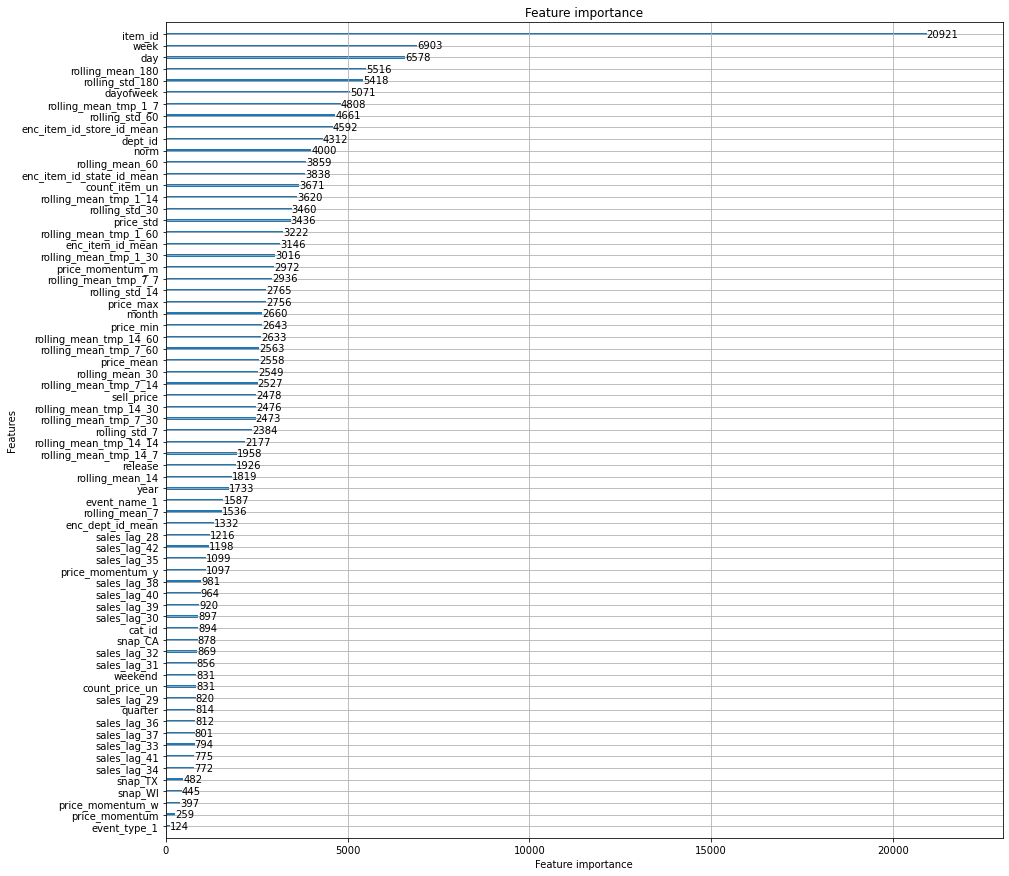

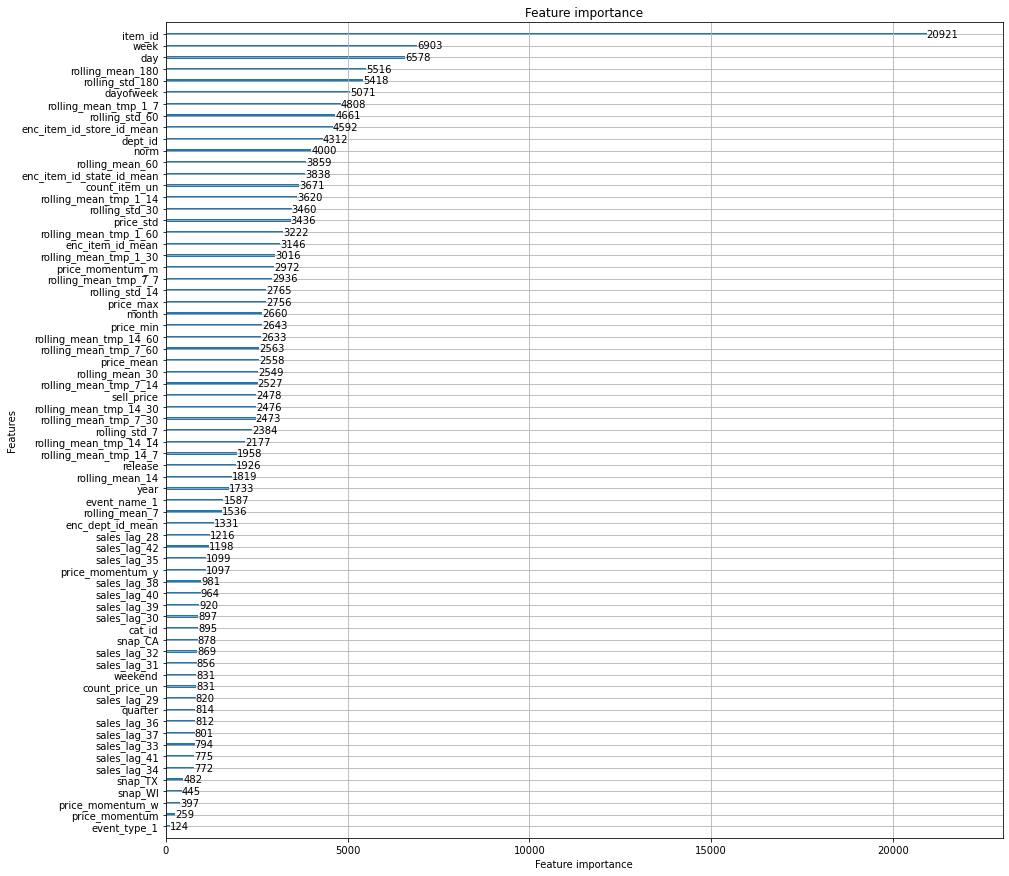

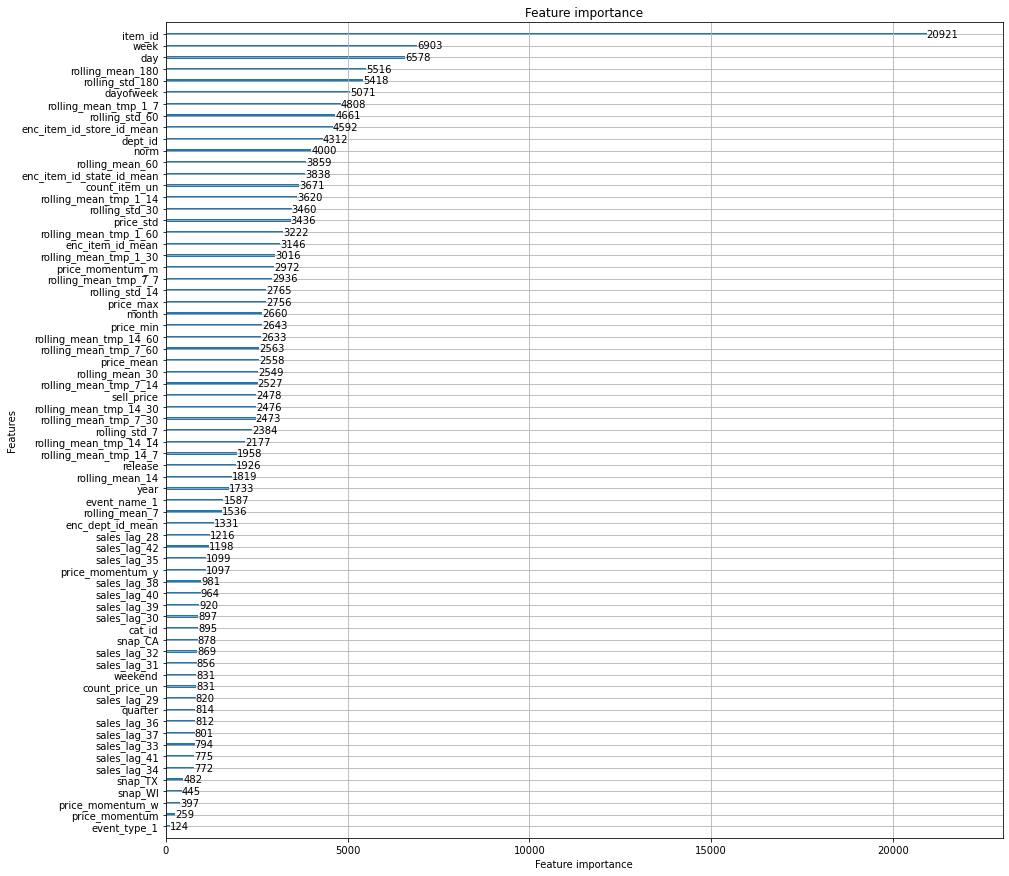

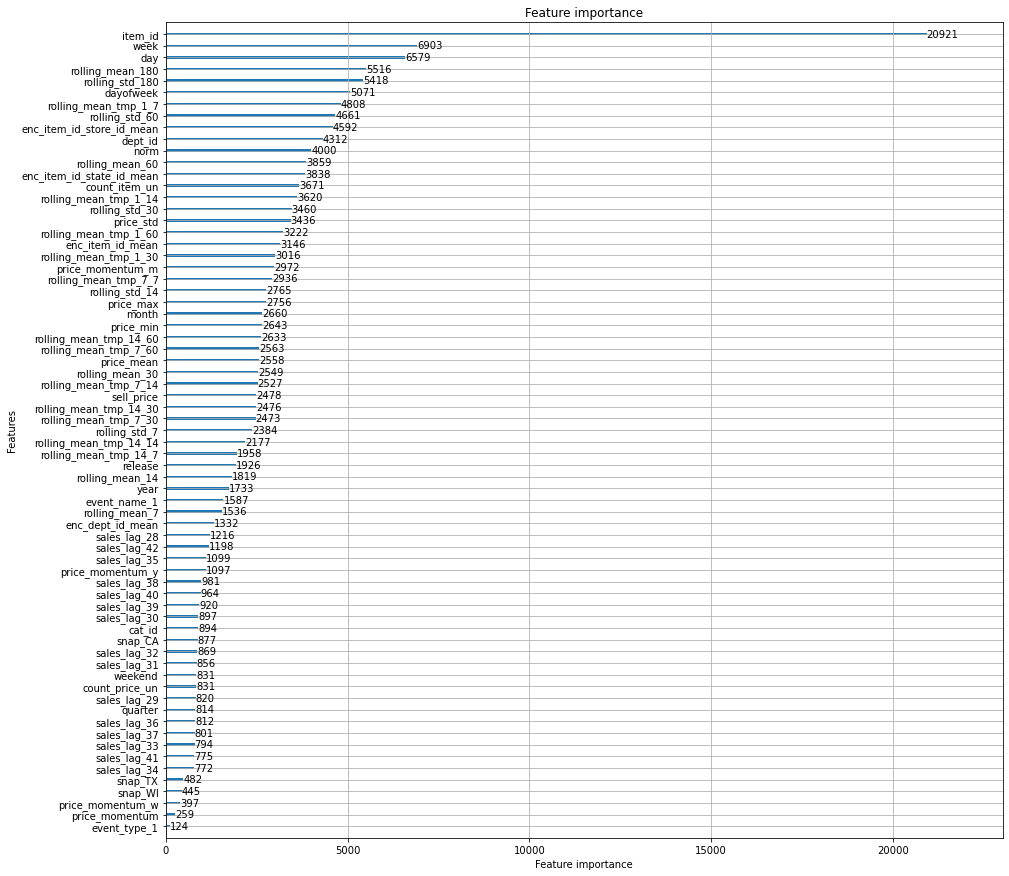

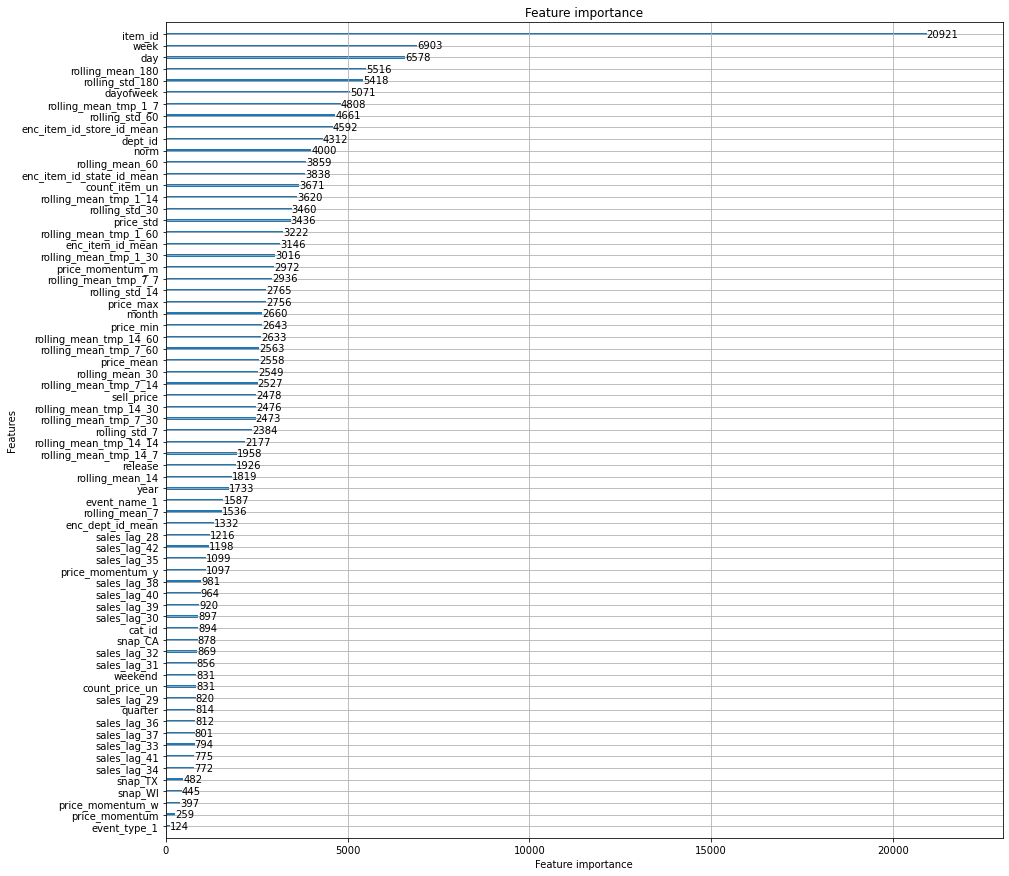

In [ ]:
%%time
NUM_ITERATIONS = 500
all_preds = []
all_val = []
val_d = {}
pred_d = {}  

stores = [
          'CA_1',
          'WI_1',
          'TX_1'
]

for store in stores:
    val = []
    preds = []  
    print(store)
    for i, st in enumerate(start, 1):
        print(f'Fold {i}')       
        df, features = read_data(store, end = st)
        tr_mask = df['d']<= st
        va_mask = (df['d']>(st)) & (df['d']<= (st+28))
        test_mask = df['d'] >= (st+28)
        model = train(df, features, tr_mask, va_mask, lgb_params, seed=False)       
        val_err = model.best_score['valid_0']['rmse']
        val.append(val_err)
        #this helper func for predict        
        temp_df = make_relo(df, st, reroll=True)
        error = predic(model, st, temp_df, features, reroll=True)       
        preds.append(error)
        print(f'Store {store} Fold {i}, interval train < {st} valid {st}-{st+28}, test > {st+28}: Valid--> {val_err}, Predict--> {error}')
        print('Ends')
    val_d[store] = val
    pred_d[store] = preds      